# TM10007 Assignment

In [77]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Load and analyse data

The number of samples: 246
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, GIST-001_0 to GIST-246_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(1)
memory usage: 951.3+ KB
None
                                                    PREDICT_original_sf_compactness_avg_2.5D  \
PREDICT_original_sf_compactness_avg_2.5D                                                True   
PREDICT_original_sf_compactness_std_2.5D                                               False   
PREDICT_original_sf_rad_dist_avg_2.5D                                                  False   
PREDICT_original_sf_rad_dist_std_2.5D                                                  False   
PREDICT_original_sf_roughness_avg_2.5D                                                 False   
...                                                                                      ...   
PREDICT_original_phasef_phasesym_peak_po

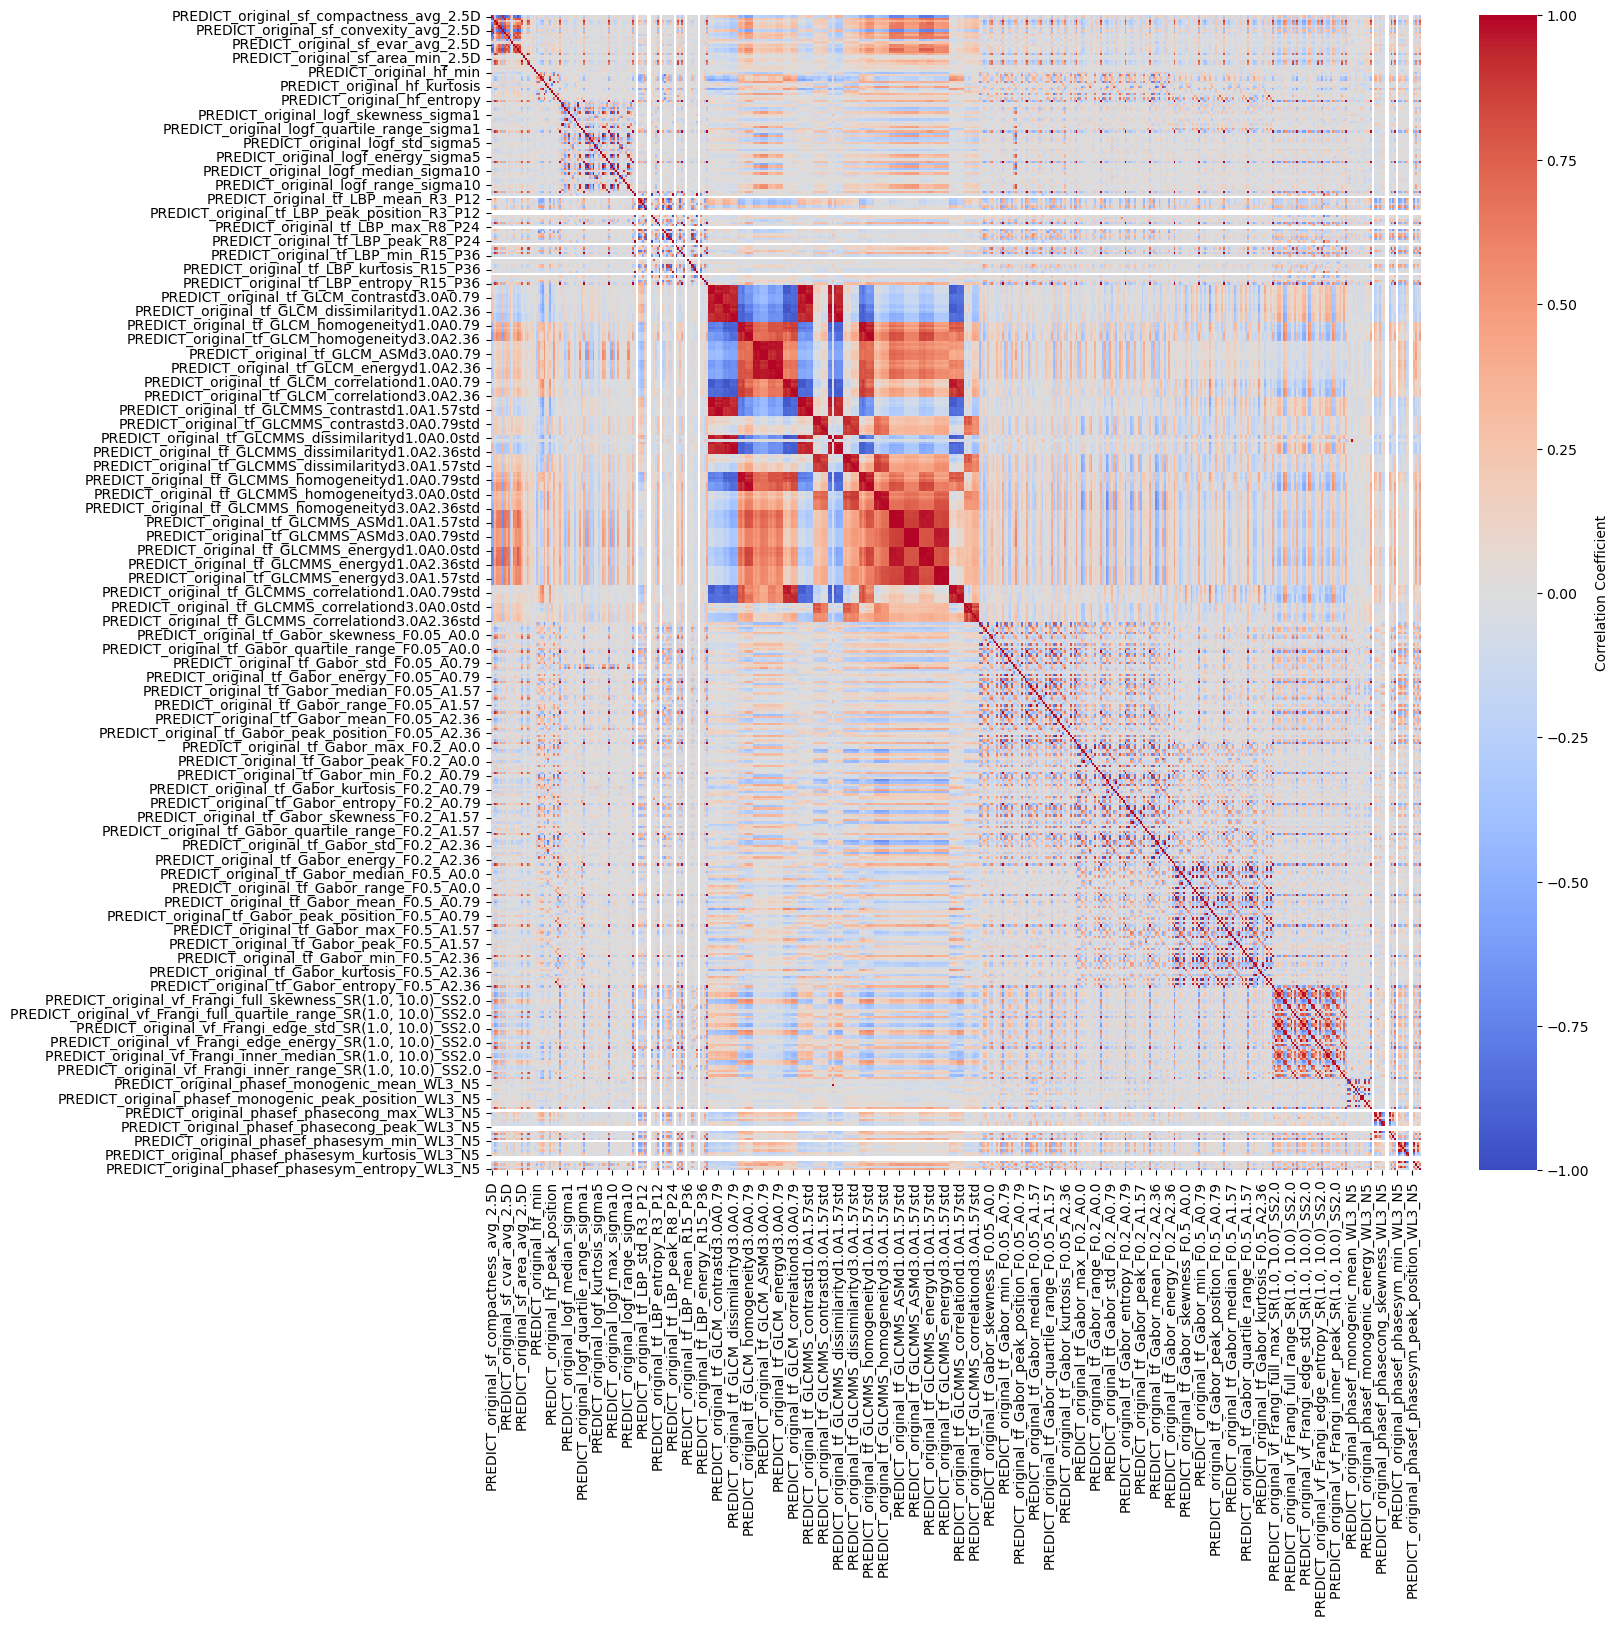

In [78]:
from load_data import load_data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

# Code used to load the original data and split into train and test set
# Was only run once at the start to create test and train dataset

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

print(data.info())

# Make a correlation matrix to analyse the correlation between the features
correlation_matrix = data.drop(columns=['label']).corr()

print(correlation_matrix > 0.9)

# Heatmap for the entire correlation matrix (for large datasets, consider reducing the size)
plt.figure(figsize=(15, 15))  # Adjust size as needed
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.show()

# Standardize the data
labels = data['label']
values = data.drop(columns=['label'])

scaler = StandardScaler()
scaled_values = scaler.fit_transform(values)

values = pd.DataFrame(scaled_values, columns=values.columns)

# Convert 'GIST' and 'non-GIST' to numeric values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # This will convert 'GIST' to 1, 'non-GIST' to 0


## Feature selection and dimension reduction

In [79]:
# First we remove NaNs by averaging
values = values.fillna(values.mean())

# First we remove features with 0 variance
print(values.shape)

print(f'We removed {values.loc[:, values.var() == 0].shape[1]} columns without any variance')
values = values.loc[:, values.var() != 0]

print(values.shape)



(246, 493)
We removed 13 columns without any variance
(246, 480)


## Random forest

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

def train_random_forest(training_values, training_labels):
    # Initialize the Random Forest Classifier
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features='sqrt',
        min_samples_leaf=5,
        random_state=42
    )

    trained_model = rf_model.fit(training_values, training_labels)

    feature_importances = trained_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': training_values.columns,
        'Importance': feature_importances
    })

    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

    top_features = feature_importance_df.head(20)['Feature'].values

    data_selected = training_values[top_features]
    labels_selected = training_labels

    cv_scores = cross_val_score(rf_model, data_selected, labels_selected, cv=5)

    return cv_scores.mean()

## KNN-classifier

In [81]:
from sklearn.neighbors import KNeighborsClassifier

def KNN(training_values, training_labels):
    knn = KNeighborsClassifier(n_neighbors=50, weights = 'distance')

    knn.fit(training_values, training_labels)

    cv_scores = cross_val_score(knn, training_values, training_labels, cv=5)

    return cv_scores.mean()


## SVM

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC

def SVM(training_values, training_labels):
    # Initialiseren van de SVM-classifiers
    clf = SVC(kernel='linear', gamma='scale')
    #svmrbf = SVC(kernel='rbf', gamma='scale')
    #svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

    clf.fit(values, labels)  # Train het model op de gehele dataset
        
    cv_scores = cross_val_score(clf, training_values, training_labels, cv=5)

    return cv_scores.mean()

## Try the different classifiers for 5 different folds

In [82]:
from sklearn.model_selection import StratifiedKFold

# 5-fold cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(values, labels)):
    print(f"\n=== Fold {fold} ===")

    training_values = values.iloc[train_index]
    training_labels = labels[train_index]

    test_values = values.iloc[test_index]
    test_labels = labels[test_index]

    forest_score = train_random_forest(training_values, training_labels)
    print(f"Fold {fold} - Random Forest Score: {forest_score:.4f}")

    knn_score = KNN(training_values, training_labels)
    print(f"Fold {fold} - KNN Score: {knn_score:.4f}")
    
#)


=== Fold 0 ===
Fold 0 - Random Forest Score: 0.5558
Fold 0 - KNN Score: 0.6265

=== Fold 1 ===
Fold 1 - Random Forest Score: 0.5579
Fold 1 - KNN Score: 0.5935

=== Fold 2 ===
Fold 2 - Random Forest Score: 0.5581
Fold 2 - KNN Score: 0.6288

=== Fold 3 ===
Fold 3 - Random Forest Score: 0.5174
Fold 3 - KNN Score: 0.6240

=== Fold 4 ===
Fold 4 - Random Forest Score: 0.5983
Fold 4 - KNN Score: 0.5881
